In [1]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
import pickle
import math

In [2]:
# LOAD DATA
# Lists of observations and targets
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

In [3]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results
    
def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring, key_replace):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace(key_replace, ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))            
        ])
        
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

def get_deafult_score(model_class, default_grid, scoring):
    default_scores = []
    for i in range(4):
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        default_scores.append(default_score)
    return default_scores

def plot_maxs_iter(path_rs, path_bs, title):
    opt_results_bs = load_result(path_bs)
    opt_results_rs = load_result(path_rs)
    maxs_rs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
    for index, key in enumerate(maxs_rs.keys()):    
        for i in range(100):
            maxs_rs[key].append(opt_results_rs[index].cv_results_["mean_test_score"][:(i+1)].max())
    
    maxs_bs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
    for index, key in enumerate(maxs_bs.keys()):    
        for i in range(100):
            maxs_bs[key].append(opt_results_bs[index].cv_results_["mean_test_score"][:(i+1)].max())

    titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
    fig, axs = plt.subplots(2, 2, figsize = (12, 6))
    axs = axs.flatten()
    fig.suptitle(title)
    for index, key in enumerate(maxs_rs.keys()):
        df = {
            'maxs': maxs_rs[key][:] + maxs_bs[key][:],
            'method': ["RandomSearch"] * 100 + ["BayesSearch"] * 100,
            'iter': [i for i in range(100)] * 2
        }
        sns.lineplot(x='iter', y='maxs', hue="method", data=df, ax=axs[index])
        axs[index].set_title(titles[index])
    plt.tight_layout()
    plt.show()

def plot_max_time(path_rs, path_bs, title, frac):
    opt_results_bs = load_result(path_bs)
    opt_results_rs = load_result(path_rs)
    maxs_rs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
    for index, key in enumerate(maxs_rs.keys()):    
        for i in range(100):
            maxs_rs[key].append(opt_results_rs[index].cv_results_["mean_test_score"][:(i+1)].max())
    
    maxs_bs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
    for index, key in enumerate(maxs_bs.keys()):    
        for i in range(100):
            maxs_bs[key].append(opt_results_bs[index].cv_results_["mean_test_score"][:(i+1)].max())

    titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
    fig, axs = plt.subplots(2, 2, figsize = (12, 6))
    axs = axs.flatten()
    fig.suptitle(title)
    for index, key in enumerate(maxs_rs.keys()):
        df = {
            'maxs': maxs_rs[key][:] + maxs_bs[key][:math.ceil(frac * 100)],
            'method': ["RandomSearch"] * 100 + ["BayesSearch"] * math.ceil(frac * 100),
            'time': [i for i in range(100)] + [i * 1/frac for i in range(math.ceil(frac * 100))]
        }
        sns.lineplot(x='time', y='maxs', hue="method", data=df, ax=axs[index])
        axs[index].set_title(titles[index])
    plt.tight_layout()
    plt.show()

# Ploty testy

### Max_iter_plot

In [4]:
rf_opt_results_bs = load_result("./saved_results/rf_opt_results_bs.pkl")
rf_opt_results_rs = load_result("./saved_results/rf_opt_results_rs.pkl")

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.4.0. This might lead to br

In [5]:
(rf_opt_results_bs[3].cv_results_["mean_fit_time"]*5).sum()/60

25.26181833346685

In [6]:
time = 0
for i in range(4):
    time += (rf_opt_results_bs[i].cv_results_["mean_fit_time"]*5).sum()/60
time

96.51542775233587

In [7]:
time = 0
for i in range(4):
    time += (rf_opt_results_rs[i].cv_results_["mean_fit_time"]*5).sum()/60
time

245.14573128223418

In [8]:
maxs_rs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}

In [9]:
maxs_rs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
for index, key in enumerate(maxs_rs.keys()):    
    for i in range(100):
        maxs_rs[key].append(rf_opt_results_rs[index].cv_results_["mean_test_score"][:(i+1)].max())

maxs_bs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
for index, key in enumerate(maxs_bs.keys()):    
    for i in range(100):
        maxs_bs[key].append(rf_opt_results_bs[index].cv_results_["mean_test_score"][:(i+1)].max())

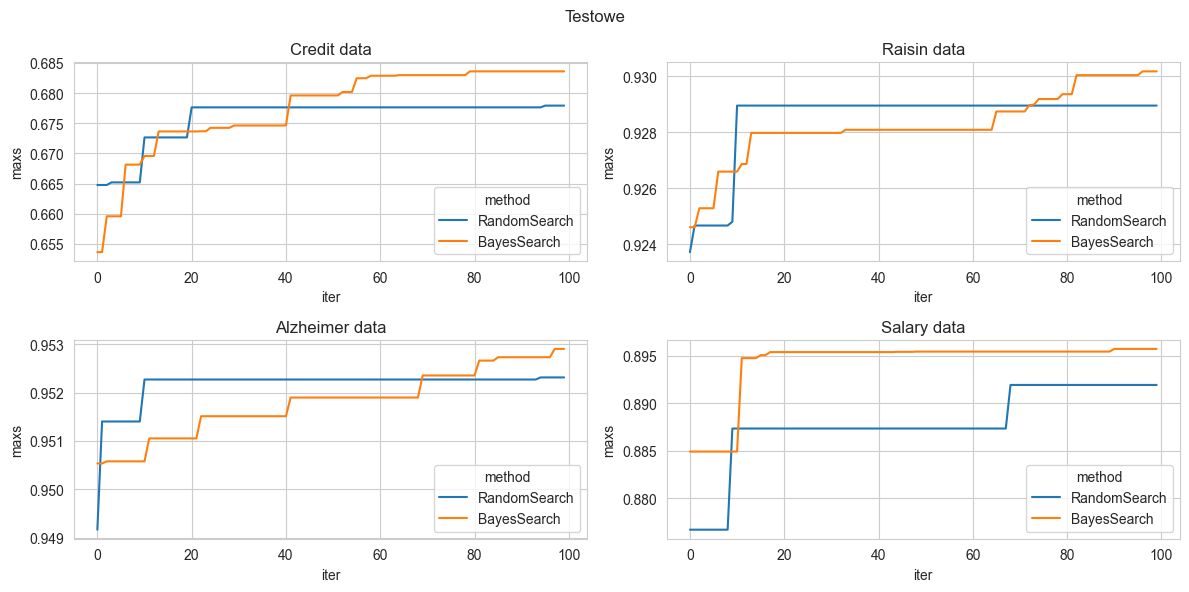

In [10]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Testowe")
for index, key in enumerate(maxs_rs.keys()):
    df = {
        'maxs': maxs_rs[key][:] + maxs_bs[key][:],
        'method': ["RandomSearch"] * 100 + ["BayesSearch"] * 100,
        'iter': [i for i in range(100)] * 2
    }
    sns.lineplot(x='iter', y='maxs', hue="method", data=df, ax=axs[index])
    axs[index].set_title(titles[index])
plt.tight_layout()
plt.show()

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.0 when using version 1.4.0. This might lead to breaki

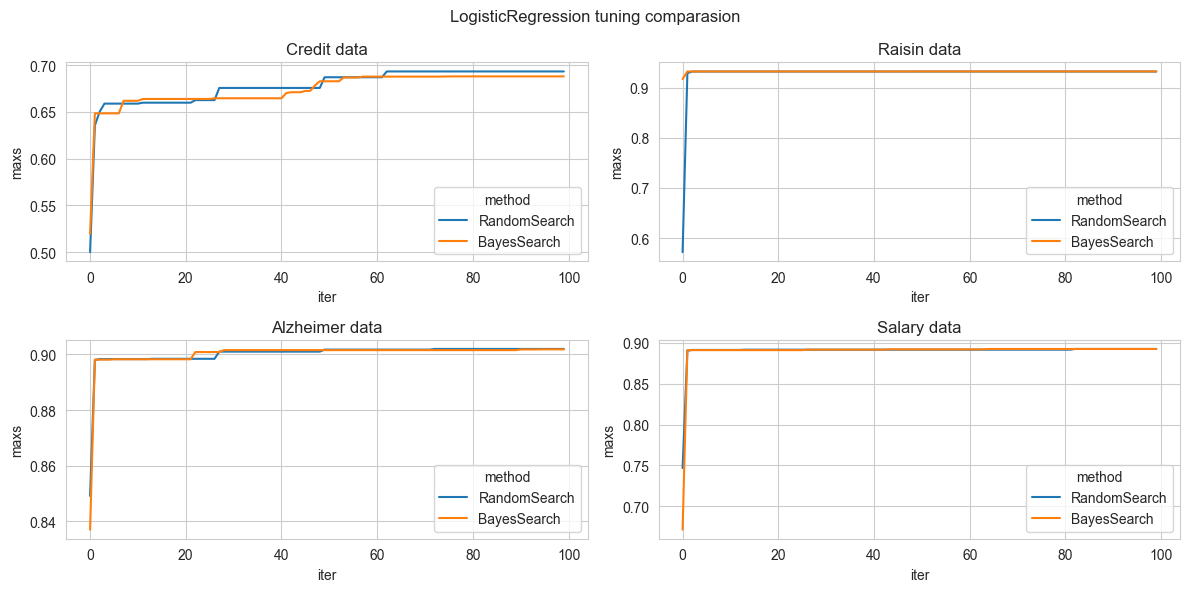

In [11]:
plot_maxs_iter("saved_results/lr_opt_results_rs.pkl", "saved_results/lr_opt_results_bs.pkl", "LogisticRegression tuning comparasion")

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.4.0. This might lead to br

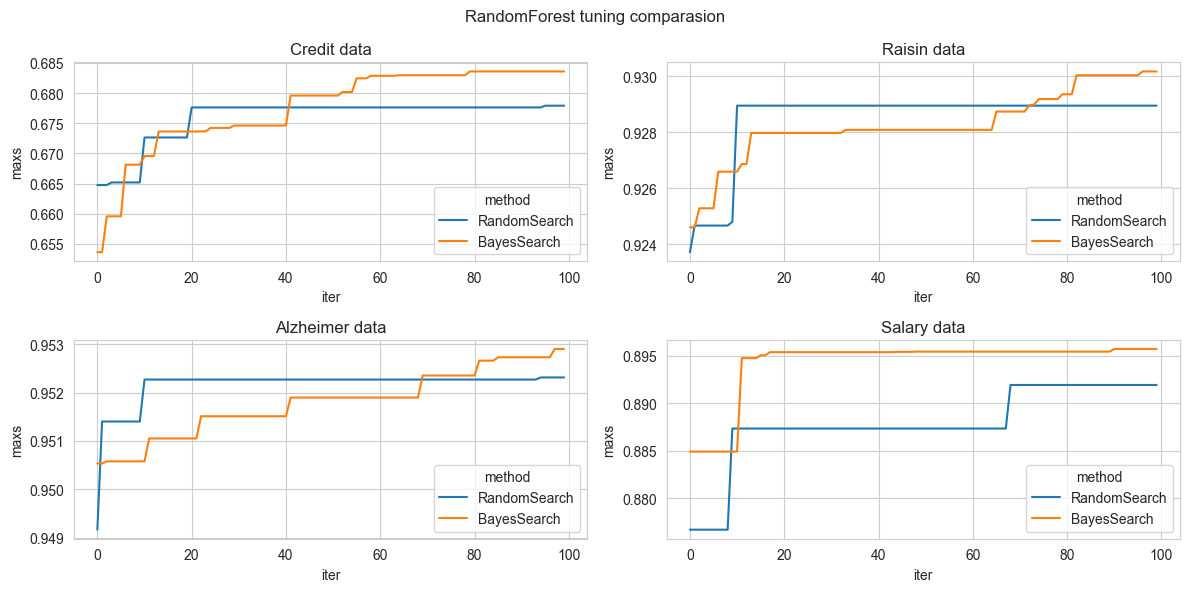

In [12]:
plot_maxs_iter("saved_results/rf_opt_results_rs.pkl", "saved_results/rf_opt_results_bs.pkl", "RandomForest tuning comparasion")

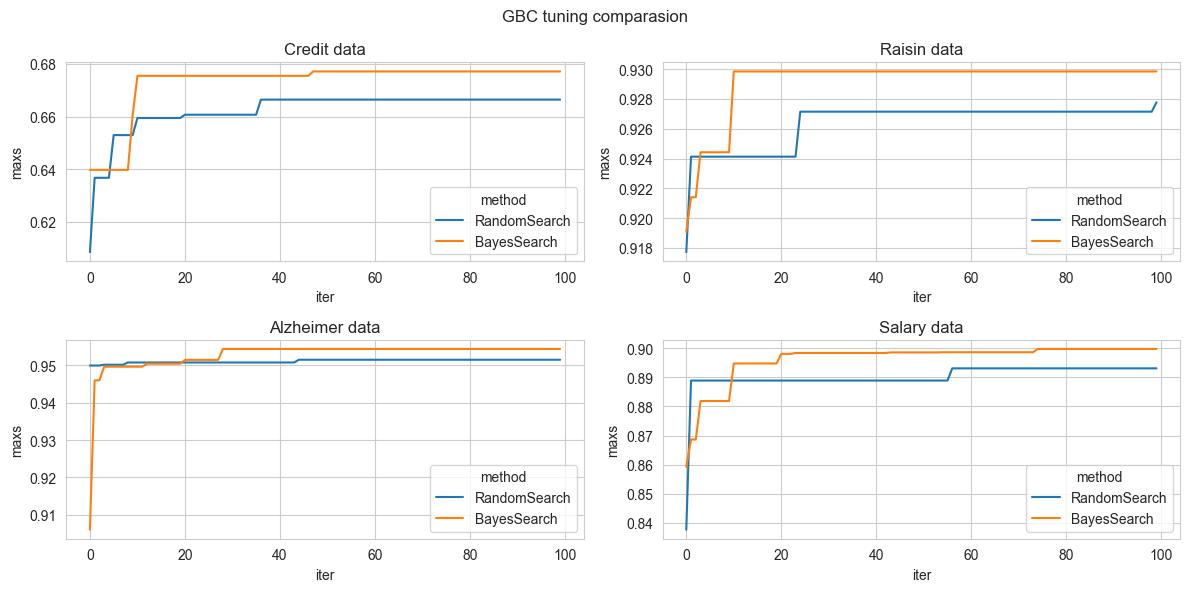

In [13]:
plot_maxs_iter("saved_results/gbc_opt_results_rs.pkl", "saved_results/gbc_opt_results_bs.pkl", "GBC tuning comparasion")

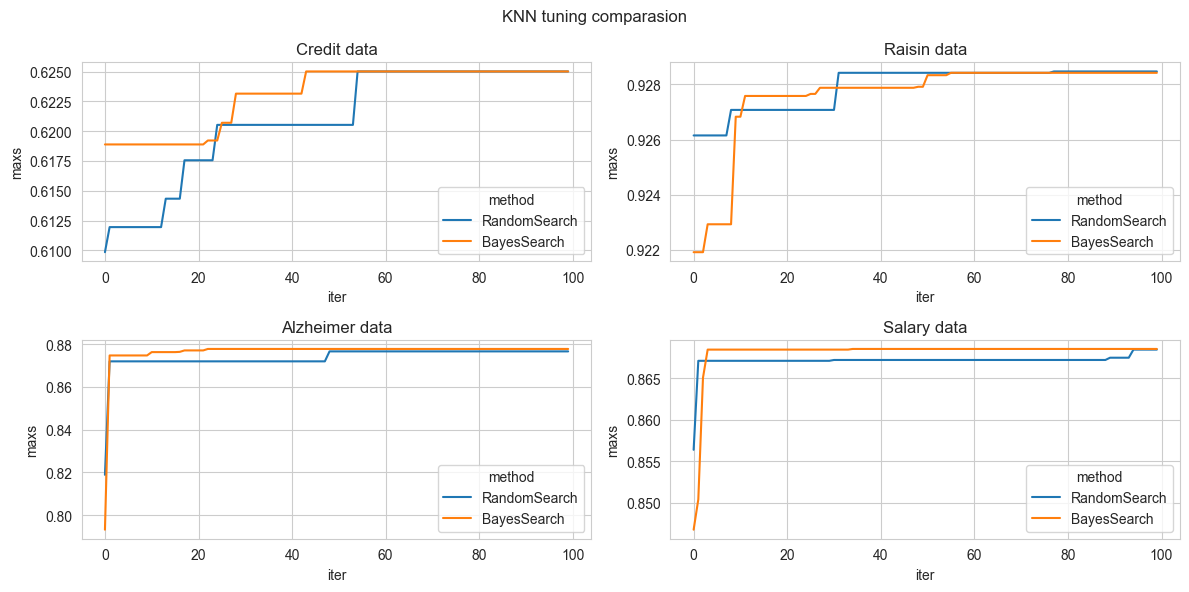

In [14]:
plot_maxs_iter("saved_results/knn_opt_results_rs.pkl", "saved_results/knn_opt_results_bs.pkl", "KNN tuning comparasion")

### Max_time_plot

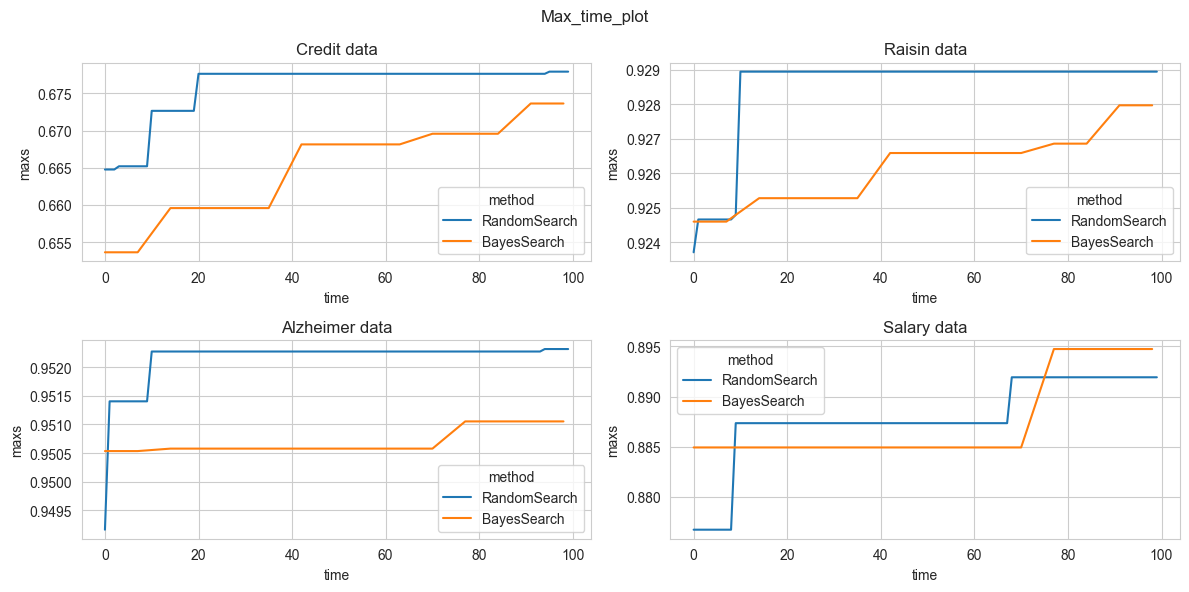

In [15]:
frac = 1/7
maxs_rs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
for index, key in enumerate(maxs_rs.keys()):    
    for i in range(100):
        maxs_rs[key].append(rf_opt_results_rs[index].cv_results_["mean_test_score"][:(i+1)].max())

maxs_bs = {"credit": [], "raisin": [], "alzheimer": [], "salary": []}
for index, key in enumerate(maxs_bs.keys()):    
    for i in range(100):
        maxs_bs[key].append(rf_opt_results_bs[index].cv_results_["mean_test_score"][:(i+1)].max())

titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Max_time_plot")
for index, key in enumerate(maxs_rs.keys()):
    df = {
        'maxs': maxs_rs[key][:] + maxs_bs[key][:math.ceil(frac * 100)],
        'method': ["RandomSearch"] * 100 + ["BayesSearch"] * math.ceil(frac * 100),
        'time': [i for i in range(100)] + [i * 1/frac for i in range(math.ceil(frac * 100))]
    }
    sns.lineplot(x='time', y='maxs', hue="method", data=df, ax=axs[index])
    axs[index].set_title(titles[index])
plt.tight_layout()
plt.show()

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.4.0. This might lead to br

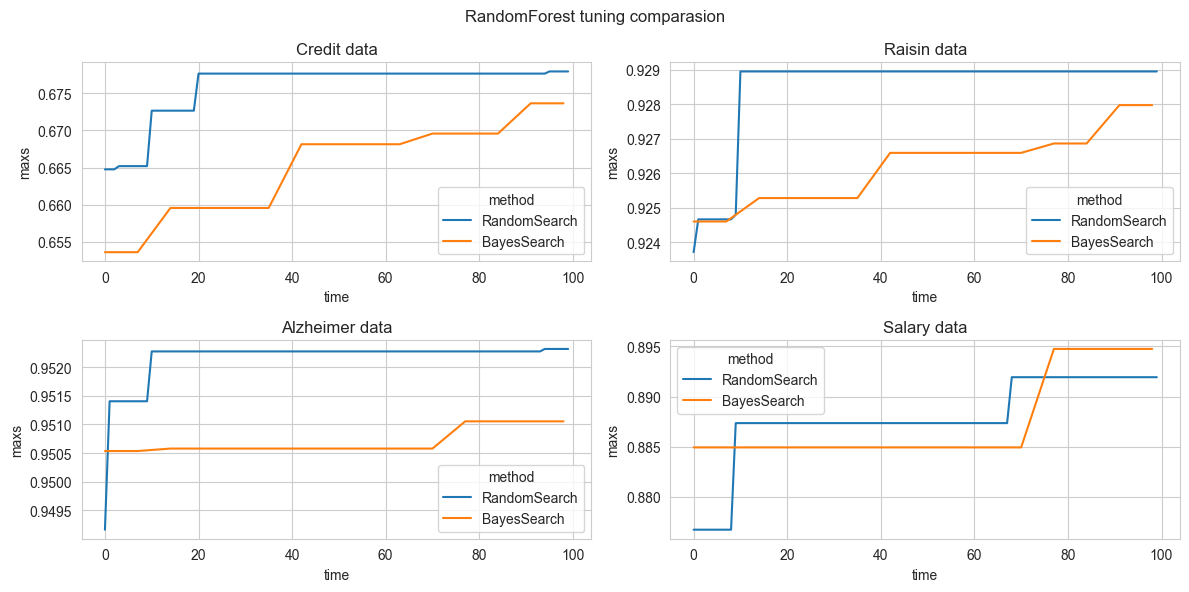

In [16]:
plot_max_time("saved_results/rf_opt_results_rs.pkl", "saved_results/rf_opt_results_bs.pkl", "RandomForest tuning comparasion", 1/7)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.0 when using version 1.4.0. This might lead to breaki

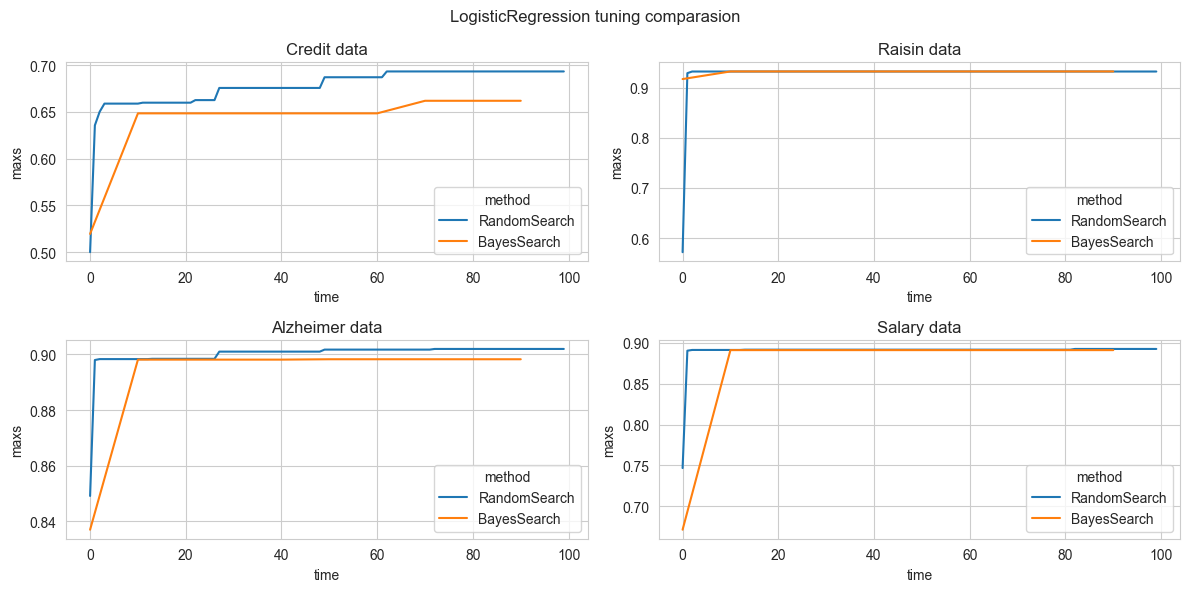

In [17]:
plot_max_time("saved_results/lr_opt_results_rs.pkl", "saved_results/lr_opt_results_bs.pkl", "LogisticRegression tuning comparasion", 1/10)

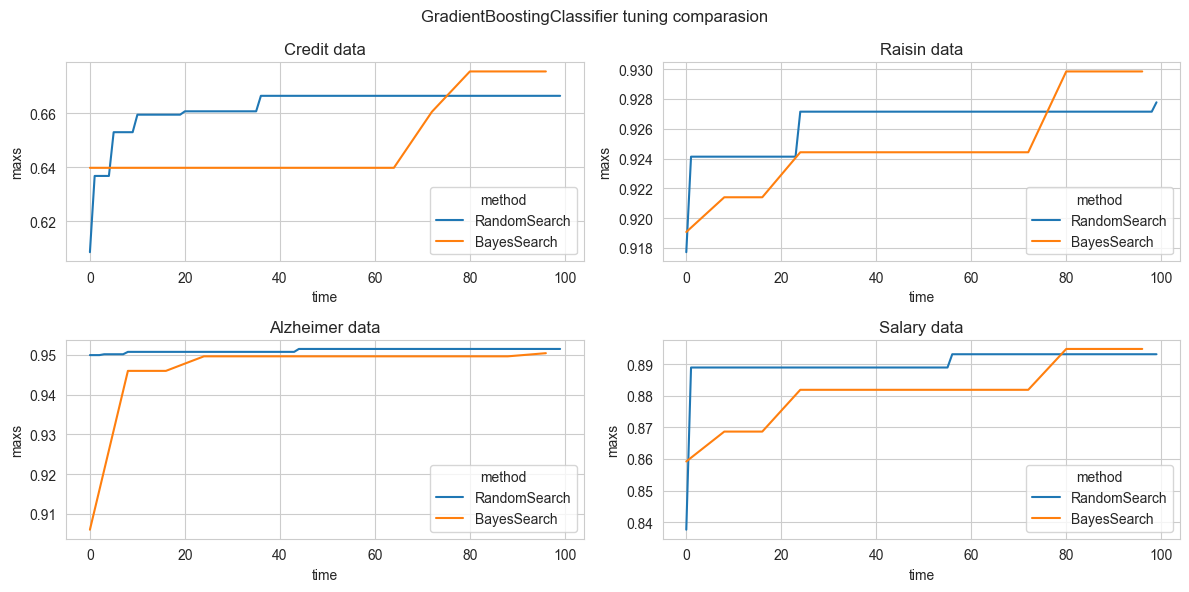

In [18]:
plot_max_time("saved_results/gbc_opt_results_rs.pkl", "saved_results/gbc_opt_results_bs.pkl", "GradientBoostingClassifier tuning comparasion", 1/8)

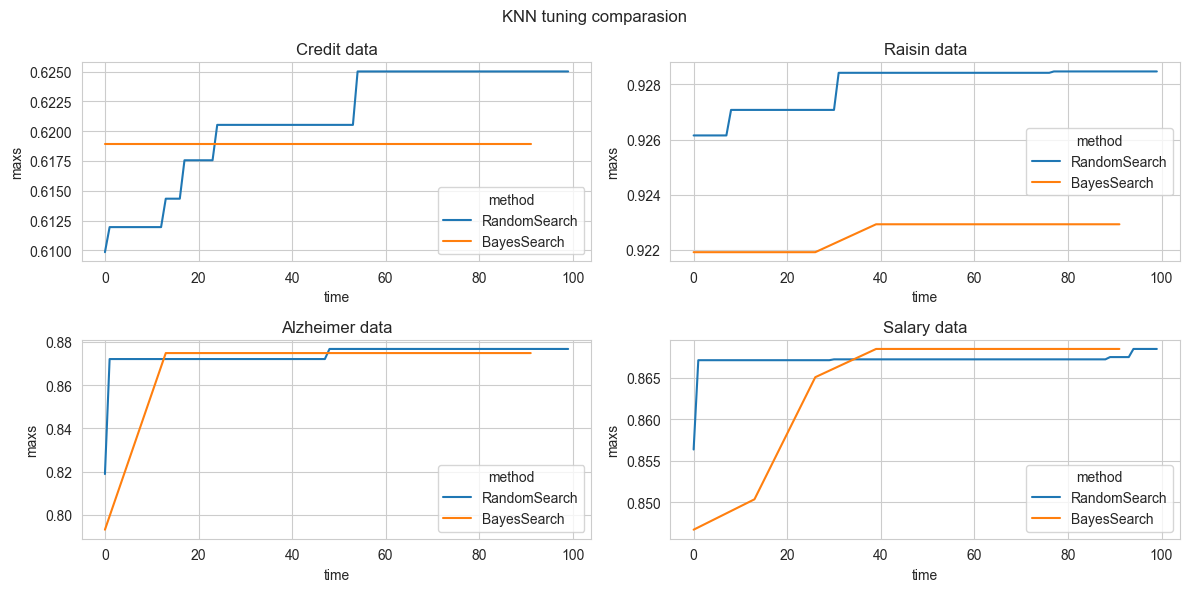

In [19]:
plot_max_time("saved_results/knn_opt_results_rs.pkl", "saved_results/knn_opt_results_bs.pkl", "KNN tuning comparasion", 1/13)

### Algoritms tunability

In [20]:
rf_opt_results_bs = load_result("./saved_results/rf_opt_results_bs.pkl")
rf_opt_results_rs = load_result("./saved_results/rf_opt_results_rs.pkl")
lr_opt_results_bs = load_result("./saved_results/lr_opt_results_bs.pkl")
lr_opt_results_rs = load_result("./saved_results/lr_opt_results_rs.pkl")
knn_opt_results_bs = load_result("./saved_results/knn_opt_results_bs.pkl")
knn_opt_results_rs = load_result("./saved_results/knn_opt_results_rs.pkl")
gbc_opt_results_bs = load_result("./saved_results/gbc_opt_results_bs.pkl")
gbc_opt_results_rs = load_result("./saved_results/gbc_opt_results_rs.pkl")

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.4.0. This might lead to br

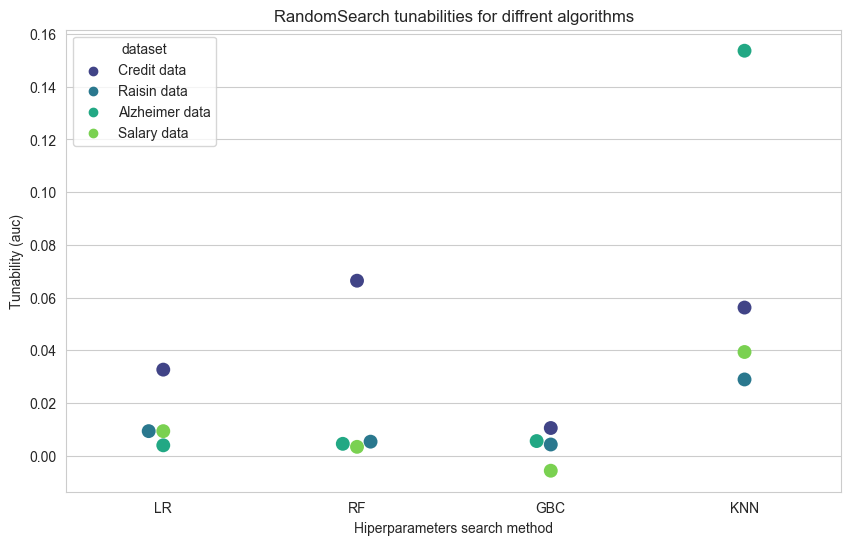

In [21]:
lr_tunabilities_rs = get_tunability(LogisticRegression, {"random_state": seed, "max_iter": 10000}, lr_opt_results_rs, "roc_auc", "model__")
rf_tunabilities_rs = get_tunability(RandomForestClassifier, {'random_state': seed, 'n_jobs': -1}, rf_opt_results_rs, "roc_auc", "model__")
gbc_tunabilities_rs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_rs, 'roc_auc', "gbc__")
knn_tunabilities_rs = get_tunability(KNeighborsClassifier, {'n_jobs': -1}, knn_opt_results_rs, 'roc_auc', "knn__")

data = {
    'tunability': lr_tunabilities_rs + rf_tunabilities_rs + gbc_tunabilities_rs + knn_tunabilities_rs,
    'alg': ["LR"] *  4 + ["RF"] * 4 + ["GBC"] * 4 + ["KNN"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*4
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('RandomSearch tunabilities for diffrent algorithms')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

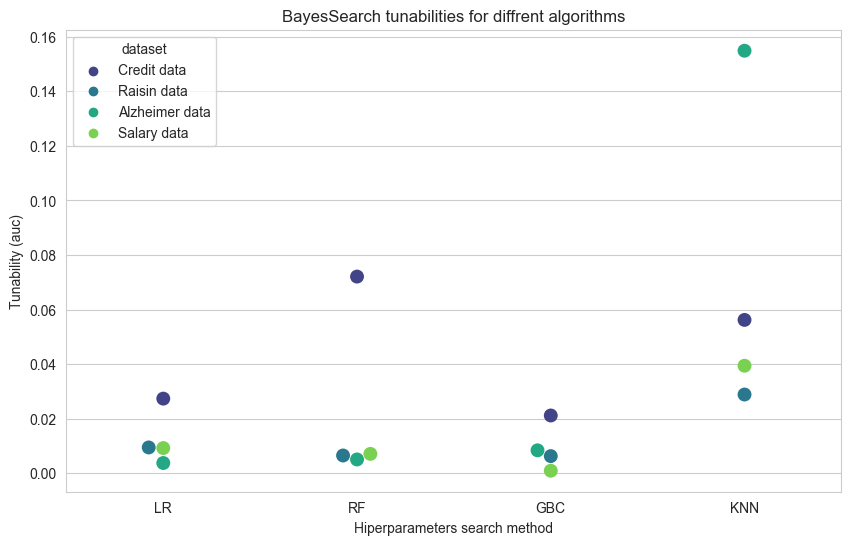

In [22]:
lr_tunabilities_bs = get_tunability(LogisticRegression, {"random_state": seed, "max_iter": 10000}, lr_opt_results_bs, "roc_auc", "model__")
rf_tunabilities_bs = get_tunability(RandomForestClassifier, {'random_state': seed, 'n_jobs': -1}, rf_opt_results_bs, "roc_auc", "model__")
gbc_tunabilities_bs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_bs, 'roc_auc', "gbc__")
knn_tunabilities_bs = get_tunability(KNeighborsClassifier, {'n_jobs': -1}, knn_opt_results_bs, 'roc_auc', "knn__")

data = {
    'tunability': lr_tunabilities_bs + rf_tunabilities_bs + gbc_tunabilities_bs + knn_tunabilities_bs,
    'alg': ["LR"] *  4 + ["RF"] * 4 + ["GBC"] * 4 + ["KNN"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*4
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('BayesSearch tunabilities for diffrent algorithms')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

### Kolejny plot

In [23]:
lr_opt_results_bs[0]

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                        ('model',
                                         LogisticRegression(multi_class='deprecated'))]),
              n_iter=100, random_state=17, scoring='roc_auc',
              search_spaces={'model__C': Real(low=0.0001, high=10000.0, prior='log-uniform', transform='normalize'),
                             'model__class_weight': Categorical(categories=(None, 'balanced'), prior=None),
                             'model__max_iter': Categorical(categories=(10000,), prior=None),
                             'model__penalty': Categorical(categories=('l1', 'l2'), prior=None),
                             'model__random_state': Categorical(categories=(17,), prior=None),
                             'model__solver': Categorical(categories=('liblinear', 'saga'), prior=None)})